In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 895 kB 45.2 MB/s 
     |████████████████████████████████| 6.5 MB 37.9 MB/s 
     |████████████████████████████████| 596 kB 51.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# 최종 모델 

KoELECTRA
- eps : 1e-8
- grad_norm 1
- lr 3e-5
- max_length 128
- train 32
- linear_warump_scheduler - warm_up_ratio 0
- weight decay 0.01
- epoch 3 (10 Epochs 수행 중 Check Point)


결과    
전처리 후[최종 성적]

F1 : 86.68076109936574    
Pearsonr : 93.31220771751511

전처리 전

F1 : 86.0169491525424   
Pearsonr : 93.20669360320977


In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/프리온보딩")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import json
import pandas as pd

with open("klue-sts-v1.1_dev.json", 'r') as file:
    test_file = json.load(file)

guid_list = []
sentence1_list = []
sentence2_list = []

for i in test_file:
  guid_list.append(i['guid'])
  sentence1_list.append(i['sentence1'])
  sentence2_list.append(i['sentence2'])

test_df = pd.DataFrame(
    {"guid" : guid_list,
     "sentence1" : sentence1_list,
     "sentence2" : sentence2_list}
)

In [4]:
test_df

,guid,sentence1,sentence2
0,klue-sts-v1_dev_00000,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다."
1,klue-sts-v1_dev_00001,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.
2,klue-sts-v1_dev_00002,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...
3,klue-sts-v1_dev_00003,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다."
4,klue-sts-v1_dev_00004,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.
...,...,...,...
514,klue-sts-v1_dev_00514,"문체부는 이를 연차적으로 확대, 시행해 학교운동부와 스포츠클럽 간의 연계를 강화한다.",문화체육관광부는 학교스포츠학과와 스포츠클럽의 연계성을 강화하기 위해 매년 이 프로그...
515,klue-sts-v1_dev_00515,일단 정확한 정보와 빠른 답변이 정말 좋았습니다.,호스트의 빠른 답변과 유용한 정보들이 정말 좋습니다.
516,klue-sts-v1_dev_00516,게스트에 대한 배려가 묻어나는 시설들이었습니다.,우선 공간에 대한 센스가 돋보이는 곳이었습니다.
517,klue-sts-v1_dev_00517,밤하늘을 배경으로 ‘비대면 드론쇼’도 펼쳐진다.,‘비대면 실감형 문화공연 플랫폼’ 개념도.


In [5]:
import re
import string

def normalize_answer(s):
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', text)
        return text

    def white_space_fix(text):  #공백을 하나로 줄이는 코드
        return ' '.join(text.split())

    def remove_punc(text): # 반점 제거
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text): # 소문자로 변경
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

def preprocess(sen):
  sen =  re.sub("((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", "",sen)
  sen = normalize_answer(sen)
  
  return sen

def apply_preprocess(df):
  """
  텍스트 전처리 진행.
  """
  df['sentence1'] = df['sentence1'].apply(normalize_answer).apply(preprocess)
  df['sentence2'] = df['sentence2'].apply(normalize_answer).apply(preprocess)

  return df

# 전처리

In [6]:
test_df = apply_preprocess(test_df)

In [7]:
set_score = pd.read_csv("기업과제3_2팀_dev_set_score.csv")
test_data = set_score.merge(test_df, on = 'guid')
test_data

,guid,true_real_label,true_binary_label,predict_real_label,predict_binary_label,sentence1,sentence2
0,klue-sts-v1_dev_00000,4.857143,1,NaN,NaN,무엇보다도 호스트분들이 너무 친절하셨습니다,무엇보다도 호스트들은 매우 친절했습니다
1,klue-sts-v1_dev_00001,1.428571,0,NaN,NaN,주요 관광지 모두 걸어서 이동가능합니다,위치는 피렌체 중심가까지 걸어서 이동 가능합니다
2,klue-sts-v1_dev_00002,1.285714,0,NaN,NaN,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...
3,klue-sts-v1_dev_00003,3.714286,1,NaN,NaN,다만 도로와 인접해서 거리의 소음이 들려요,하지만 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다
4,klue-sts-v1_dev_00004,2.500000,0,NaN,NaN,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요,가족 모임 일정은 바꾸지 말도록 하십시오
...,...,...,...,...,...,...,...
514,klue-sts-v1_dev_00514,2.200000,0,NaN,NaN,문체부는 이를 연차적으로 확대 시행해 학교운동부와 스포츠클럽 간의 연계를 강화한다,문화체육관광부는 학교스포츠학과와 스포츠클럽의 연계성을 강화하기 위해 매년 이 프로그...
515,klue-sts-v1_dev_00515,2.833333,0,NaN,NaN,일단 정확한 정보와 빠른 답변이 정말 좋았습니다,호스트의 빠른 답변과 유용한 정보들이 정말 좋습니다
516,klue-sts-v1_dev_00516,0.333333,0,NaN,NaN,게스트에 대한 배려가 묻어나는 시설들이었습니다,우선 공간에 대한 센스가 돋보이는 곳이었습니다
517,klue-sts-v1_dev_00517,0.333333,0,NaN,NaN,밤하늘을 배경으로 비대면 드론쇼 도 펼쳐진다,비대면 실감형 문화공연 플랫폼 개념도


# Dataset 생성

In [8]:
from torch.utils.data import Dataset, DataLoader, SequentialSampler

class CustomDataset(Dataset):
    """
    데이터 프레임의 입력을 받아 (input, target) 형태의 Dataset 생성
    """
    def __init__(self, data) -> None: 
        self.data = data            
        self.input, self.label = list(zip(self.data['sentence1'], self.data['sentence2'])), self.data['true_real_label']

    def __len__(self):
        return len(self.label) # len(y)

    def __getitem__(self, index):
        return self.input[index], self.label[index] # getitem 호출 시 tuple 형태로 x, y 반환

In [9]:
def custom_collate_fn(batch):
    """
  한 배치 내 문장(input)들을 tokenizing 한 후 텐서로 변환함. 
    """
    global tokenizer
  
    input_list, target_list = zip(*batch) #(input_list, target_list)를 list가 감싸고 있기 때문에 unpacking(*) 후에 zip으로 할당
    tensorized_input = tokenizer.batch_encode_plus(
        # input_list
        [(sentences[0], sentences[1]) for sentences in input_list],
        max_length = 128, # model_setting
        padding= "max_length",
        add_special_tokens=True,
        truncation=True,
        return_tensors='pt',
    )
    
    tensorized_label = torch.tensor(target_list)
  
    return tensorized_input, tensorized_label

In [10]:
test_dataset = CustomDataset(test_data)

In [11]:
test_dataset[0]

(('무엇보다도 호스트분들이 너무 친절하셨습니다', '무엇보다도 호스트들은 매우 친절했습니다'), 4.857142857142857)

In [12]:
test_dataloader = DataLoader(test_dataset, batch_size = 64, sampler = SequentialSampler(test_dataset), collate_fn = custom_collate_fn)

# 모델 불러오기

In [13]:
from transformers import ElectraForSequenceClassification, ElectraTokenizer

model = ElectraForSequenceClassification.from_pretrained("./final_model/best_model")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

In [14]:
import torch
# device type
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"# available GPUs : {torch.cuda.device_count()}")
        print(f"GPU name : {torch.cuda.get_device_name()}")
    else:
        device = torch.device("cpu")
    return device
device = set_device()
device

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB


device(type='cuda')

# 스코어 계산

In [15]:
from scipy.stats import pearsonr
from sklearn.metrics import f1_score
import numpy as np

def test(model, dataloader, device):    
    """
    훈련된 모델의 Test Dataset 성능을 확인합니다.
    """  
    model.to(device)
    model.eval()
    
    total_loss = 0
    batch_count, batch_loss = 0, 0
    preds_np = None

    for step, batch in enumerate(dataloader):       
        batch_count += 1
        batch = tuple(item.to(device) for item in batch)

        batch_input, batch_label = batch

        with torch.no_grad():
            outputs = model(**batch_input, labels = batch_label)
    
        loss = outputs.loss
        preds = outputs.logits.squeeze()

        
        # 모델 예측 값과 Label 값 저장.
        if preds_np is None:
            preds_np = preds.detach().cpu().numpy()
            labels_np = batch_label.detach().cpu().numpy()
        else:
            preds_np = np.append(preds_np, preds.detach().cpu().numpy(), axis=0)
            labels_np = np.append(labels_np, batch_label.detach().cpu().numpy(), axis=0)
        
        batch_loss += loss.item()
        total_loss += loss.item()
                        
        # 배치 처리할 때마다 평균 loss와 f1_score, pearsonr을 출력
        if (step % 10) == 0 and step != 0:
            print('valid_loss : ' ,batch_loss / batch_count)                           
            batch_loss, batch_count = 0, 0

    total_valid_loss = total_loss / (step + 1)
    # binary_preds
    preds_f = np.where(preds_np >=3, 1, 0)
    labels_f = np.where(labels_np >=3, 1, 0)
       
    f_score = f1_score(preds_f, labels_f) * 100
    p_score = pearsonr(preds_np, labels_np)[0] * 100           
    print('total_valid_loss : ' , total_valid_loss, "total_f1_score : " , f_score, "total_pearsonr:" , p_score)

    return preds_np, preds_f

## 전처리 후

In [27]:
predict_real_label, predict_binary_label = test(model, test_dataloader, device)

total_valid_loss :  0.28993834696194914 total_f1_score :  86.68076109936574 total_pearsonr: 93.31220771751511


In [29]:
test_data['predict_real_label'] = predict_real_label
test_data['predict_binary_label'] = predict_binary_label
test_data = test_data.drop(['sentence1', 'sentence2'], axis = 1)

In [31]:
test_data.to_csv("기업과제3_2팀_dev_set_score.csv", index = False)

# 결과 분석

In [18]:
df = test_data

In [19]:
df.head()

,guid,true_real_label,true_binary_label,predict_real_label,predict_binary_label,sentence1,sentence2
0,klue-sts-v1_dev_00000,4.857143,1,4.815647,1,무엇보다도 호스트분들이 너무 친절하셨습니다,무엇보다도 호스트들은 매우 친절했습니다
1,klue-sts-v1_dev_00001,1.428571,0,2.285277,0,주요 관광지 모두 걸어서 이동가능합니다,위치는 피렌체 중심가까지 걸어서 이동 가능합니다
2,klue-sts-v1_dev_00002,1.285714,0,0.778822,0,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...
3,klue-sts-v1_dev_00003,3.714286,1,4.042777,1,다만 도로와 인접해서 거리의 소음이 들려요,하지만 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다
4,klue-sts-v1_dev_00004,2.500000,0,2.815743,0,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요,가족 모임 일정은 바꾸지 말도록 하십시오


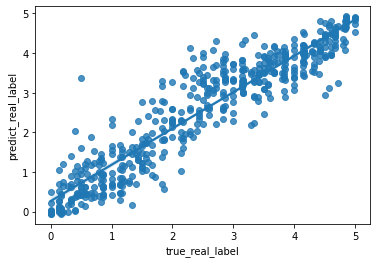

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 분석
sns.regplot(data = df, x=df.true_real_label, y=df.predict_real_label)

In [22]:
df_cor = df[['true_real_label', 'predict_real_label']]


df_cor.describe()

,true_real_label,predict_real_label
count,519.000000,519.000000
mean,2.484778,2.542772
std,1.477751,1.449975
min,0.000000,-0.058881
25%,1.154762,1.183347
50%,2.571429,2.936894
75%,3.800000,3.772943
max,5.000000,4.928387


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


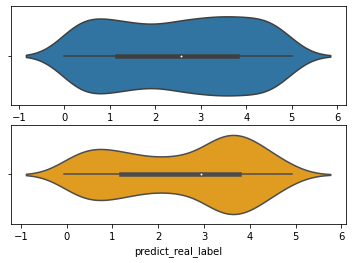

In [23]:
fig, axes = plt.subplots(2,1)
x=df.true_real_label
y=df.predict_real_label
sns.violinplot(x, ax =axes[0])
sns.violinplot(y, ax = axes[1], color='orange')

### f1 score : 0.8668

precision : 0.81 
recall : 0.93

### recall>> precision?
- 유사하지 않은데 유사하다고 예측한 것(fp)이 유사한데 유사하지 않다고 예측한 것(fn)보다 많다. 
- 모델은 대체로 실제보다 유사하다고 예측하는 비율이 높다.
- threshold 값을 조금씩 낮추면서 성능을 비교하면 더 높은 f1 score를 기대해 볼 수 있다.

In [24]:
# confusion matrix
# f1 score
from sklearn import metrics

df_bin = df[['true_binary_label', 'predict_binary_label']]
y_label=df_bin.true_binary_label
y_pred=df_bin.predict_binary_label
confusion_mat = metrics.confusion_matrix(y_label, y_pred, labels=[0,1])
print()
tn, fp, fn, tp = confusion_mat.ravel()
print(f'PRECISION : {tp/(tp+fp)}')
print(f'RECALL : {tp/(tp+fn)}')

print(f'F1 SCORE : {metrics.f1_score(y_label, y_pred)}')
print(confusion_mat)


PRECISION : 0.8102766798418972
RECALL : 0.9318181818181818
F1 SCORE : 0.8668076109936574
[[251  48]
 [ 15 205]]


In [25]:
print(metrics.classification_report(y_label, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       299
           1       0.81      0.93      0.87       220

    accuracy                           0.88       519
   macro avg       0.88      0.89      0.88       519
weighted avg       0.89      0.88      0.88       519



In [26]:
!ls

 기업과제3_2팀_dev_set_score_analysis.ipynb
 기업과제3_2팀_dev_set_score.ipynb
 기업과제3_2팀.ipynb
 data_preprocessing.ipynb
 dev_set_score.csv
 final_model
 final_model2
 fine_tuning.ipynb
 klue-roberta
 klue_roberta_sen
 klue-sts-all-train.csv
 klue-sts-ss-3_new.tsv
 klue-sts-ss-3.tsv
 klue-sts-ss.tsv
 klue-sts-test.csv
 klue-sts-test.tsv
 klue-sts-train-aug.tsv
 klue-sts-train.csv
 klue-sts-train-final.csv
 klue-sts-v1.1_dev.json
 klue-sts-v1.1_train.json
 klue-sts-valid-aug.tsv
 klue-sts-valid-final.csv
 major-sweep-1-2-98.92375368678363
 model
 model.ckpt.0
 model.ckpt.0.13
 model.ckpt.0.19
 model.ckpt.0.21
 model.ckpt.0.22
 model.ckpt.0.23
 model.ckpt.0.24
 model.ckpt.0.25
 model.ckpt.0.26
 model.ckpt.0.28
 model.ckpt.0.29
 model.ckpt.0.34
 model.ckpt.0.35
 model.ckpt.1
 model.ckpt.2
 model.ckpt.3
 model.ckpt.4
 model.ckpt.5
 model.ckpt.6
 monologg-sts-valid.csv
 proud-sweep-6
'Screenshot from 2022-03-24 15-26-04.png'
 silver_dataset.csv
 test
 test.ipynb
 wandb
